# Cirrhosis

## Library

In [211]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
from xgboost import XGBClassifier

from scipy.stats import shapiro
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE

## Preprocessing

### Understanding Data

In [2]:
df= pd.read_csv('1A.tsv', sep='\t')
print(df.shape)
df.head()

(418, 18)


,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


We can examine the structure of the Cirrhosis dataset.
- Based on df.shape, the dataset consists of 418 rows and 18 columns.
- df.head() displays 5 sample rows of the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         418 non-null    int64  
 1   Registration Date          418 non-null    object 
 2   Drug                       312 non-null    object 
 3   Birth Date                 418 non-null    object 
 4   Gender                     418 non-null    object 
 5   Ascites                    312 non-null    object 
 6   Hepatomegaly               312 non-null    object 
 7   Edema                      418 non-null    object 
 8   Bilirubin                  418 non-null    float64
 9   Cholesterol                80 non-null     float64
 10  Albumin                    418 non-null    float64
 11  Copper                     310 non-null    float64
 12  Alkaline Phospatase (U/L)  312 non-null    float64
 13  SGOT                       312 non-null    float64

Here, we check the data types and the presence of NULL values in each column.

**Data Types**
- The Birth Date column should be of type date.
- The data types of the other columns are correct.

**NULL Values**
- There are 10 columns with NULL values.
- The columns Drug, Ascites, Hepatomegaly, Cholesterol, Copper, Alkaline Phosphatase (U/L), SGOT, Platelets, Prothrombin, and Stage contain NULL values.

### Delete Identifier

In [4]:
df.nunique()

ID                           418
Registration Date            399
Drug                           5
Birth Date                   344
Gender                         2
Ascites                        2
Hepatomegaly                   2
Edema                          3
Bilirubin                     98
Cholesterol                   69
Albumin                      154
Copper                       158
Alkaline Phospatase (U/L)    295
SGOT                         179
Tryglicerides                147
Platelets                    243
Prothrombin                   48
Stage                          4
dtype: int64

- Out of 418 rows, the ID column has 418 unique values, and the Registration Date column has 399 unique values. This indicates that these columns are identifiers and lack analytical value, so they should be dropped.

- Although the Birth Date, Alkaline Phosphatase (U/L), and Platelets columns have high unique values, these columns contain useful information for analysis or prediction. Therefore, they should not be dropped.

In [5]:
df= df.drop(columns=['ID'])
df= df.drop(columns=['Registration Date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Drug                       312 non-null    object 
 1   Birth Date                 418 non-null    object 
 2   Gender                     418 non-null    object 
 3   Ascites                    312 non-null    object 
 4   Hepatomegaly               312 non-null    object 
 5   Edema                      418 non-null    object 
 6   Bilirubin                  418 non-null    float64
 7   Cholesterol                80 non-null     float64
 8   Albumin                    418 non-null    float64
 9   Copper                     310 non-null    float64
 10  Alkaline Phospatase (U/L)  312 non-null    float64
 11  SGOT                       312 non-null    float64
 12  Tryglicerides              418 non-null    float64
 13  Platelets                  407 non-null    float64

### Change Data Type

In [7]:
df['Birth Date'] = pd.to_datetime(df['Birth Date'])

- The Birth Date column’s data type should be changed from Object to Date because it represents date information.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Drug                       312 non-null    object        
 1   Birth Date                 418 non-null    datetime64[ns]
 2   Gender                     418 non-null    object        
 3   Ascites                    312 non-null    object        
 4   Hepatomegaly               312 non-null    object        
 5   Edema                      418 non-null    object        
 6   Bilirubin                  418 non-null    float64       
 7   Cholesterol                80 non-null     float64       
 8   Albumin                    418 non-null    float64       
 9   Copper                     310 non-null    float64       
 10  Alkaline Phospatase (U/L)  312 non-null    float64       
 11  SGOT                       312 non-null    float64       
 12  Tryglice

- The Birth Date column now has the correct data type.

### Check Missing Values

In [9]:
print(df.isnull().sum())

Drug                         106
Birth Date                     0
Gender                         0
Ascites                      106
Hepatomegaly                 106
Edema                          0
Bilirubin                      0
Cholesterol                  338
Albumin                        0
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Tryglicerides                  0
Platelets                     11
Prothrombin                    2
Stage                          6
dtype: int64


In [10]:
print(df.isnull().sum() / len(df) * 100)

Drug                         25.358852
Birth Date                    0.000000
Gender                        0.000000
Ascites                      25.358852
Hepatomegaly                 25.358852
Edema                         0.000000
Bilirubin                     0.000000
Cholesterol                  80.861244
Albumin                       0.000000
Copper                       25.837321
Alkaline Phospatase (U/L)    25.358852
SGOT                         25.358852
Tryglicerides                 0.000000
Platelets                     2.631579
Prothrombin                   0.478469
Stage                         1.435407
dtype: float64


- 80.86% of the Cholesterol column consists of NULL values, making it infeasible to handle these NULL values by dropping them. Additionally, imputing with values like the mean or median could introduce bias and distort the original data representation, as cholesterol levels are individual medical information that cannot be estimated. To maintain data integrity, I decided to entirely remove the Cholesterol column from the dataset.

- For the Drug, Ascites, Hepatomegaly, Copper, Alkaline Phosphatase (U/L), and SGOT columns, I will drop NA. These columns retain important information useful for predictive analysis of the Stage column. I won’t perform imputation to avoid distorting the original data representation.

- For the Platelets and Stage columns, I will also drop NA since the number of NULL values is minimal, so removing them will not affect the analysis or model to be built. Again, I won’t perform imputation to preserve the data’s integrity.

Conclusion:
- Drop the Cholesterol column.
- Drop NA in other columns.

### Handling Missing Values

In [11]:
df= df.drop(columns=['Cholesterol'])

- Dropped the Cholesterol column (80.86% NULL values).

In [12]:
df= df.dropna()

- Dropped rows with NULL values in other columns.

In [13]:
print(df.isnull().sum())

Drug                         0
Birth Date                   0
Gender                       0
Ascites                      0
Hepatomegaly                 0
Edema                        0
Bilirubin                    0
Albumin                      0
Copper                       0
Alkaline Phospatase (U/L)    0
SGOT                         0
Tryglicerides                0
Platelets                    0
Prothrombin                  0
Stage                        0
dtype: int64


- No columns with NULL values remain.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306 entries, 0 to 311
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Drug                       306 non-null    object        
 1   Birth Date                 306 non-null    datetime64[ns]
 2   Gender                     306 non-null    object        
 3   Ascites                    306 non-null    object        
 4   Hepatomegaly               306 non-null    object        
 5   Edema                      306 non-null    object        
 6   Bilirubin                  306 non-null    float64       
 7   Albumin                    306 non-null    float64       
 8   Copper                     306 non-null    float64       
 9   Alkaline Phospatase (U/L)  306 non-null    float64       
 10  SGOT                       306 non-null    float64       
 11  Tryglicerides              306 non-null    float64       
 12  Platelets    

- Data entries are consistent across columns, indicating no NULL values remain.
- After removing missing values, 306 rows of data remain.

### Check Duplicated Data

In [15]:
print(df.duplicated().sum())

0


- No duplicated data exists, so no further cleaning for duplicates is required.

### Change Birth Date Column

In [16]:
def calculate_age(born):
    today= datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

df['Age']= df['Birth Date'].apply(calculate_age)
df= df.drop(columns=['Birth Date'])


- I converted the Birth Date column to Age for easier analysis. Using the Age column eliminates the need to calculate age every time, making the data more efficient to work with. Moreover, age is more relevant for analysis, such as identifying patterns and relationships with other variables. Additionally, creating graphs becomes simpler and more direct since the data is already numeric.

- After creating the Age column, the Birth Date column can be removed as it’s no longer needed.

In [17]:
df.head()

,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Age
0,D-penicillamine,F,Y,Y,Y,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4,58
1,D-penicillamine,F,N,Y,N,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3,56
2,D-penicillamine,M,N,N,S,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4,70
3,D-penicillamine,F,N,Y,S,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4,54
4,Placebo,F,N,Y,N,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3,38


- The Age column has been created.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306 entries, 0 to 311
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Drug                       306 non-null    object 
 1   Gender                     306 non-null    object 
 2   Ascites                    306 non-null    object 
 3   Hepatomegaly               306 non-null    object 
 4   Edema                      306 non-null    object 
 5   Bilirubin                  306 non-null    float64
 6   Albumin                    306 non-null    float64
 7   Copper                     306 non-null    float64
 8   Alkaline Phospatase (U/L)  306 non-null    float64
 9   SGOT                       306 non-null    float64
 10  Tryglicerides              306 non-null    float64
 11  Platelets                  306 non-null    float64
 12  Prothrombin                306 non-null    float64
 13  Stage                      306 non-null    object 
 14 

- The Age column’s data type is correct.

## EDA

### Split Data (Categorial & Numerical)

In [19]:
category= []
numerical= []

for i in df.columns:
  if 'int'in str(df[i].dtype) or 'float' in str(df[i].astype):
    numerical.append(i)
  elif 'object'in str(df[i].dtype) :
    category.append(i)

print(f'Categorial Columns: {category}')
print(f'Numerical Columns: {numerical}')

Categorial Columns: ['Drug', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']
Numerical Columns: ['Bilirubin', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Age']


### Distribution of Numerical Data

In [20]:
df[numerical].describe()

,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Age
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,3.304902,3.516471,98.281046,1984.867974,123.001046,112.627451,262.140523,10.735294,49.480392
std,4.560918,0.420435,85.974373,2146.359160,56.908529,72.459633,95.745341,1.006860,10.581205
min,0.300000,1.960000,4.000000,289.000000,26.350000,-1.000000,62.000000,9.000000,26.000000
25%,0.800000,3.310000,41.250000,862.500000,80.950000,74.000000,200.000000,10.000000,41.250000
50%,1.400000,3.550000,73.000000,1264.000000,115.475000,102.500000,257.000000,10.600000,49.000000
75%,3.500000,3.790000,123.750000,1990.000000,151.900000,145.750000,323.500000,11.175000,56.000000
max,28.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,78.000000


- The statistical summary provides information on central tendencies, dispersion, minimum and maximum values, and quartiles for numerical data.

- The count of each column shows the number of non-empty entries (Non-NULL values) for each attribute. The fact that the count equals the number of rows (306) indicates no missing values.

- **Central Tendencies:**

  - Alkaline Phosphatase (U/L) has the widest mean and min-max range, indicating patient condition variations in the dataset.

  - Copper, SGOT, Triglycerides, and Platelets also show notable mean and min-max ranges.

- **Dispersion:**
  - The high standard deviation values in Alkaline Phosphatase (U/L), Copper, SGOT, Triglycerides, and Platelets reinforce the evidence of wide data variation and dispersion.

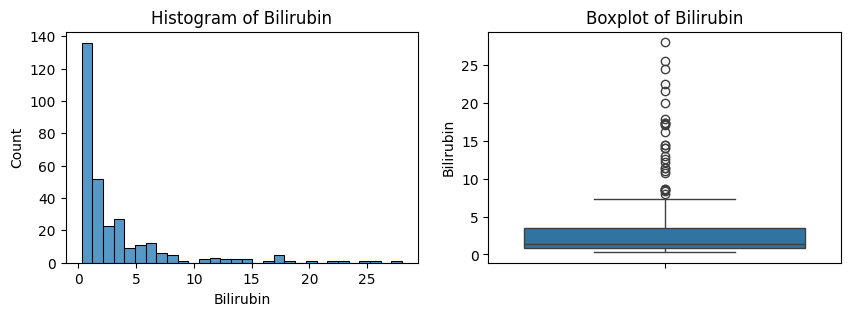

Bilirubin- skewness: 2.817540214492091
Bilirubin- kurtosis: 8.680667490516994


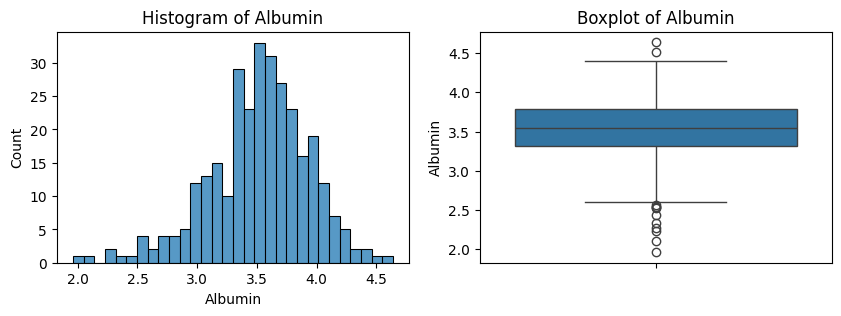

Albumin- skewness: -0.5782674450898165
Albumin- kurtosis: 0.9638761384912069


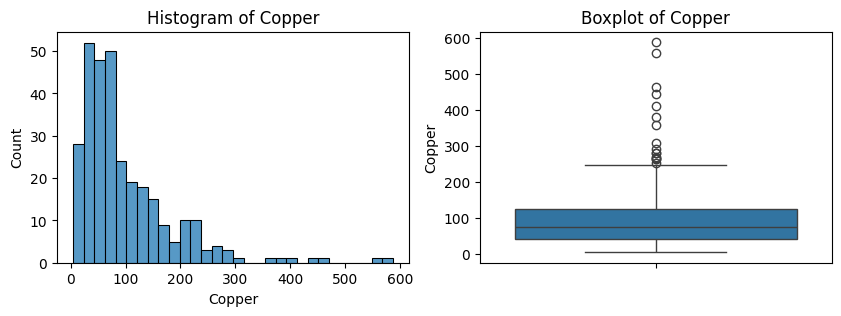

Copper- skewness: 2.2856431823652814
Copper- kurtosis: 7.515563507128517


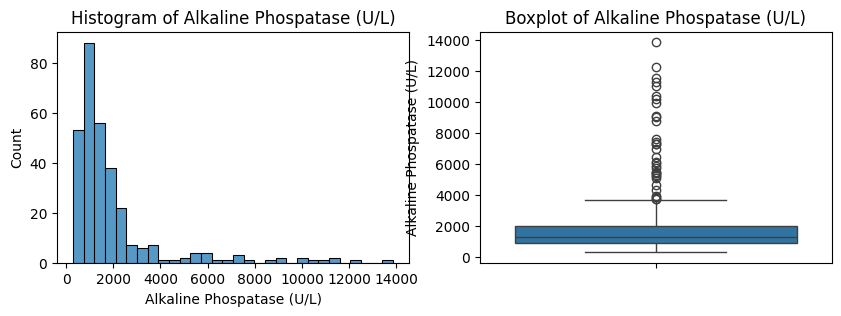

Alkaline Phospatase (U/L)- skewness: 3.005139813159215
Alkaline Phospatase (U/L)- kurtosis: 9.723126571888724


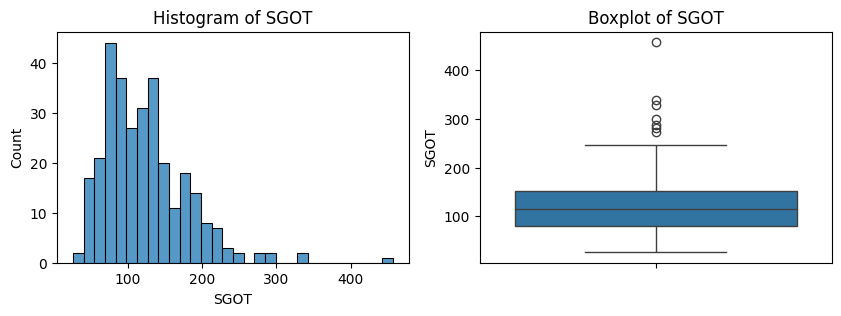

SGOT- skewness: 1.4474186250483927
SGOT- kurtosis: 4.289812936450611


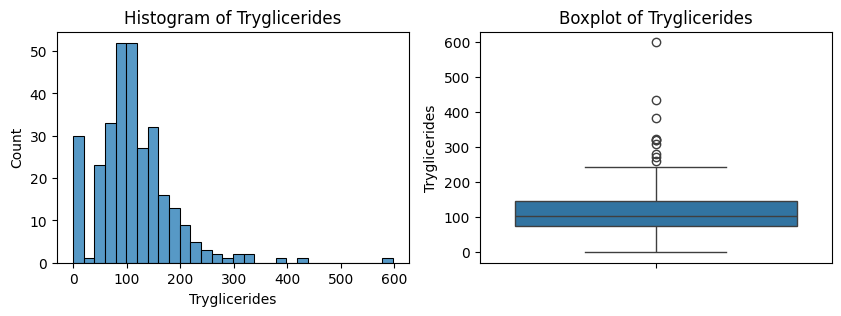

Tryglicerides- skewness: 1.673768524651463
Tryglicerides- kurtosis: 7.7356324734000665


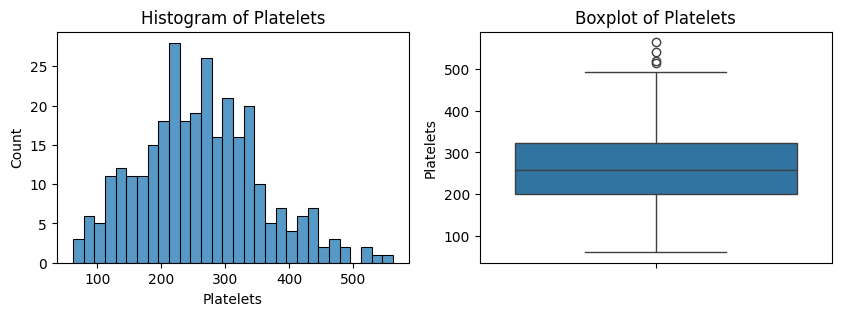

Platelets- skewness: 0.3734854844035126
Platelets- kurtosis: -0.005941626677032907


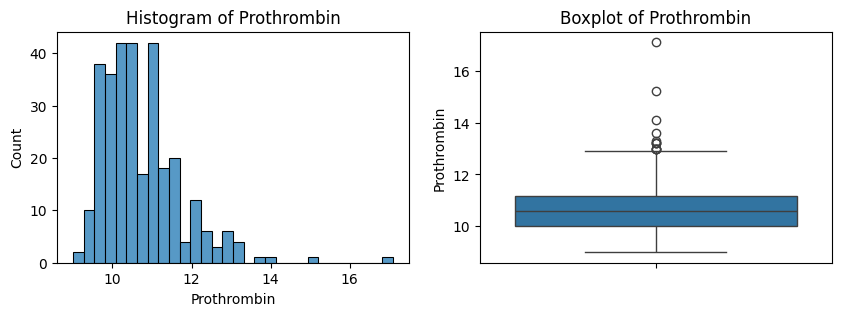

Prothrombin- skewness: 1.7392944630320002
Prothrombin- kurtosis: 6.018483343031384


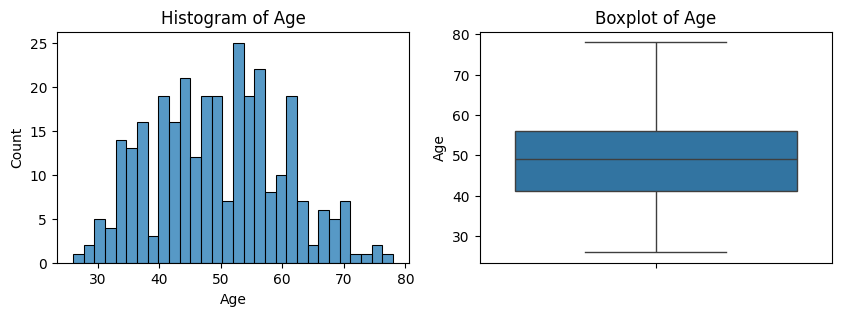

Age- skewness: 0.1744082615846146
Age- kurtosis: -0.5159317765592006


In [21]:
def dist_plot(df, numerical_cols):
  for i in numerical_cols:
    plt.figure(figsize=(10,3))

    plt.subplot(1,2,1)
    sns.histplot(df[i], bins=30)
    plt.title(f"Histogram of {i}")

    plt.subplot(1,2,2)
    sns.boxplot(df[i])
    plt.title(f"Boxplot of {i}")

    plt.show()

    print(f"{i}- skewness: {df[i].skew()}")
    print(f"{i}- kurtosis: {df[i].kurt()}")

dist_plot(df[numerical],numerical)

- The plot results reveal outliers in several numerical columns. However, I will not remove these outliers as they are reasonable due to the varying conditions of individual patients.

- Most variables (except Albumin, Platelets, and Age) exhibit positively skewed distributions with high positive kurtosis, indicating extreme values and outliers. This observation is corroborated by boxplot graphs showing outliers.

- Variables like Albumin, Platelets, and Age are more symmetric, approximating a normal distribution.

- The graphs demonstrate a wide variation in each column, reflecting diverse patient health conditions. Most patients are aged 40 to 55, with an age range of approximately 25 to 80.

In [22]:
for i in numerical:
  print(i,":\n", shapiro(df[i]), "\n")

Bilirubin :
 ShapiroResult(statistic=0.626072883605957, pvalue=2.651746072139116e-25) 

Albumin :
 ShapiroResult(statistic=0.9797792434692383, pvalue=0.0002575731778051704) 

Copper :
 ShapiroResult(statistic=0.790023922920227, pvalue=1.4634368244893354e-19) 

Alkaline Phospatase (U/L) :
 ShapiroResult(statistic=0.6123024225234985, pvalue=1.0898550976911643e-25) 

SGOT :
 ShapiroResult(statistic=0.9120213985443115, pvalue=2.141211036602031e-12) 

Tryglicerides :
 ShapiroResult(statistic=0.8889103531837463, pvalue=3.843880576792809e-14) 

Platelets :
 ShapiroResult(statistic=0.9880037307739258, pvalue=0.012351727113127708) 

Prothrombin :
 ShapiroResult(statistic=0.8831713199615479, pvalue=1.5519903477602057e-14) 

Age :
 ShapiroResult(statistic=0.9891015887260437, pvalue=0.021665753796696663) 



- Columns not normally distributed (p-value < 0.05):
  - Bilirubin, Albumin, Copper, Alkaline Phosphatase (U/L), SGOT, Triglycerides, Platelets, Prothrombin, and Age.

- Columns normally distributed (p > 0.05):
  - None.

- Since all numerical columns have a p-value < 0.05, none are normally distributed. Therefore, we will use a robust scaler for scaling.



### Distribution of Categorial Data

In [23]:
for i in category:
  print(df[i].value_counts(), '\n')

Drug
D-penicillamine    152
Placebo            149
d-penicillamine      3
placebo              1
lacebo               1
Name: count, dtype: int64 

Gender
F    271
M     35
Name: count, dtype: int64 

Ascites
N    283
Y     23
Name: count, dtype: int64 

Hepatomegaly
Y    156
N    150
Name: count, dtype: int64 

Edema
N    258
S     28
Y     20
Name: count, dtype: int64 

Stage
stage_3    118
Stage4     108
Stage 2     65
Stage 1     15
Name: count, dtype: int64 



- Here, we examine the distribution of variable types across categorical columns. However, some anomalies are present.

#### Anomalies Discovery

- The data reveals some anomalies. In the Drug column, there are spelling errors like "d-penicillamine," "placebo," and "lacebo," which should be standardized to "D-penicillamine" and "Placebo." Failing to address these anomalies could result in misinterpretation, as categories that are actually the same would be considered different, affecting statistical analysis and model-building by skewing category counts.

- In the Stage column, variations like "stage_3," "Stage4," "Stage 2," and "Stage 1" need to be standardized for better consistency and clarity. These inconsistencies could complicate data interpretation and further processing.

- Therefore, addressing these anomalies is necessary before analyzing categorical column distributions.

#### Handle Anomalies

In [24]:
def clean_drug_name(drug_name):
    if drug_name.lower() in ['d-penicillamine', 'd-penicillamine ']:
        return 'D-penicillamine'
    elif drug_name.lower() in ['placebo', 'lacebo']:
        return 'Placebo'
    return drug_name

df['Drug'] = df['Drug'].apply(clean_drug_name)

- Corrected spelling in the Drug column to "D-penicillamine" and "Placebo."

In [25]:
def clean_stage_name(stage_name):
    return ' '.join(stage_name.replace('_', ' ').replace('Stage', 'Stage ').split()).title()

df['Stage'] = df['Stage'].apply(clean_stage_name)

- Standardized spelling in the Stage column to the format "Stage [number]."


#### Re-check Categorial Distribution

In [26]:
for i in category:
  print(df[i].value_counts(), '\n')

Drug
D-penicillamine    155
Placebo            151
Name: count, dtype: int64 

Gender
F    271
M     35
Name: count, dtype: int64 

Ascites
N    283
Y     23
Name: count, dtype: int64 

Hepatomegaly
Y    156
N    150
Name: count, dtype: int64 

Edema
N    258
S     28
Y     20
Name: count, dtype: int64 

Stage
Stage 3    118
Stage 4    108
Stage 2     65
Stage 1     15
Name: count, dtype: int64 





After addressing data anomalies, categorical distributions can be accurately interpreted.

- Drug:

  - 155 patients used D-penicillamine, while 151 patients used Placebo.

  - The balance in drug usage allows for unbiased analysis of both drugs' effectiveness.

- Gender:

  - Female patients dominate, numbering 271, compared to only 35 male patients.

  - This discrepancy suggests that Cirrhosis may be more common in females.

- Ascites:

  - Most patients (283) did not have ascites (fluid buildup in the abdominal cavity), while 23 did.

  - This imbalance shows that the dataset is dominated by patients without ascites.

- Hepatomegaly:

  - 156 patients experienced hepatomegaly (enlarged liver), slightly more than the 150 who did not.

  - This balance suggests hepatomegaly is a common condition.

- Edema:

  - Most patients (258) did not have edema (swelling from fluid accumulation). This aligns with Ascites data, where most patients (283) did not have fluid buildup, making edema unlikely.

-   28 patients had treatable edema, while 20 had edema resistant to diuretics.

  - The data suggests edema is relatively rare among the patients studied.

- Stage:

  - Most patients were in advanced stages: 118 in stage 3 and 108 in stage 4.

  - Few patients were in early stages: 65 in stage 2 and 15 in stage 1.

  - These findings emphasize the importance of early detection to prevent disease progression.

The imbalanced distribution could lead to class imbalance in machine learning models, making predictions for early stages (1 and 2) less accurate. This issue could be mitigated using data balancing techniques like oversampling minority classes or employing class weights in Random Forest or sample weights in XGBoost.

### Correlation Analysis

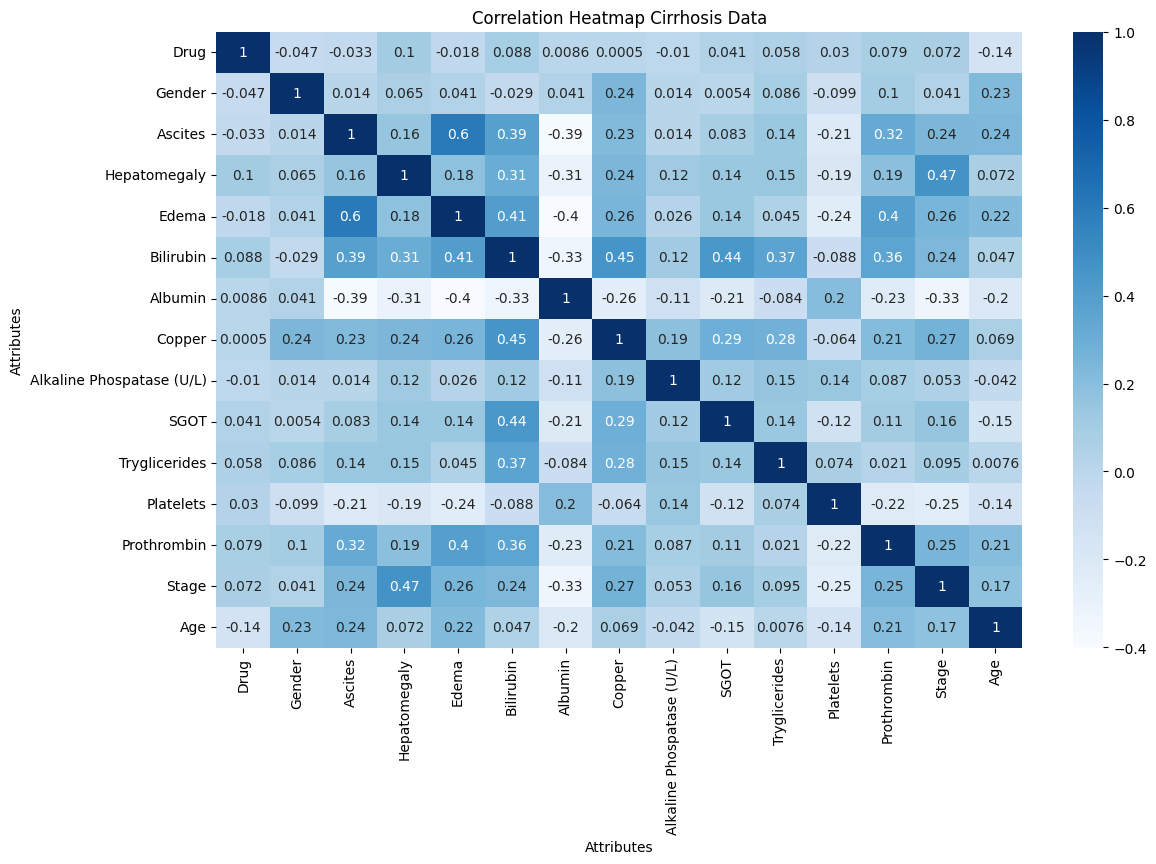

In [27]:
encoded_data = df.copy()

label_encoder = LabelEncoder()
for col in encoded_data.select_dtypes(include=['object']).columns:
    encoded_data[col] = label_encoder.fit_transform(encoded_data[col].astype(str))

correlation_matrix_all = encoded_data.corr()

plt.figure(figsize=(13, 8))
sns.heatmap(correlation_matrix_all, annot=True, cmap="Blues")
plt.title("Correlation Heatmap Cirrhosis Data")
plt.xlabel("Attributes")
plt.ylabel("Attributes")
plt.show()

**Correlation with the Stage Column (Target):**
- Hepatomegaly shows the strongest correlation with Stage (0.47), indicating that hepatomegaly is a significant predictor of Cirrhosis stage.

- Ascites, Edema, Bilirubin, Copper, and Prothrombin have weaker correlations (around 0.2), suggesting they contribute less to the target column.

- Columns Drug, Gender, Alkaline Phosphatase, and Triglycerides exhibit very weak correlations, with values close to 0. These columns could potentially be removed, but their distributions against the target column (Stage) will be analyzed first.

**Inter-Attribute Relationships:**

- Edema and Ascites have a high correlation (0.6), validating the earlier observation of a relationship between edema and fluid accumulation (Ascites).

- Bilirubin moderately correlates with SGOT (0.44), suggesting that increased bilirubin often accompanies elevated SGOT, an indicator of liver damage.

- Copper moderately correlates with Bilirubin (0.45), highlighting a potential link between copper levels and liver function.

### Bivariate Distribution with Stage Attribute

#### Stage dan Drug

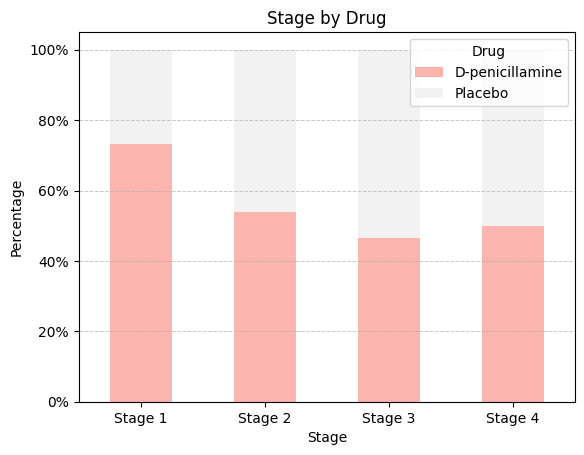

In [28]:
ax= (df.groupby('Stage')['Drug'].value_counts(normalize=True)
   .unstack('Drug')
   .plot.bar(stacked=True, colormap='Pastel1')
)

plt.xticks(rotation=0)
plt.title('Stage by Drug')
plt.xlabel('Stage')
plt.ylabel('Percentage')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

- The drug D-penicillamine is more commonly used in stages 1 and 2, while Placebo is more frequently used in stage 3. In stage 4, the frequency of usage of both drugs is almost the same, so there is no significant difference in their usage at this stage.

- Since a fairly significant distribution is still visible in each class, Drug still has a correlation with the target column. Therefore, I will not remove this column.

#### Stage dan Gender

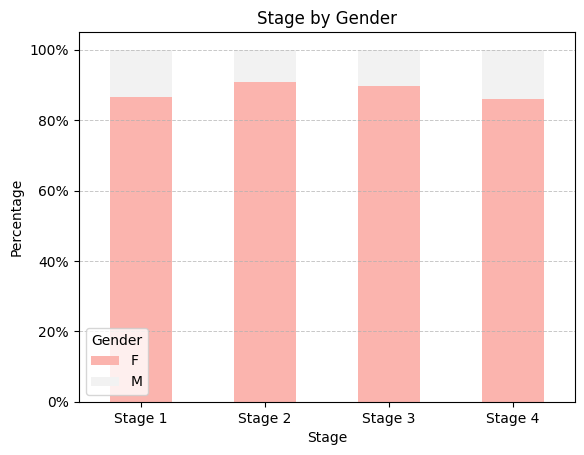

In [29]:
ax= (df.groupby('Stage')['Gender'].value_counts(normalize=True)
   .unstack('Gender')
   .plot.bar(stacked=True, colormap='Pastel1')
)

plt.xticks(rotation=0)
plt.title('Stage by Gender')
plt.xlabel('Stage')
plt.ylabel('Percentage')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

- Female gender dominates in all stages of Cirrhosis.

- Since a fairly significant distribution is still visible in each class, Gender still has a correlation with the target column. Therefore, I will not remove this column.

#### Stage dan Ascites

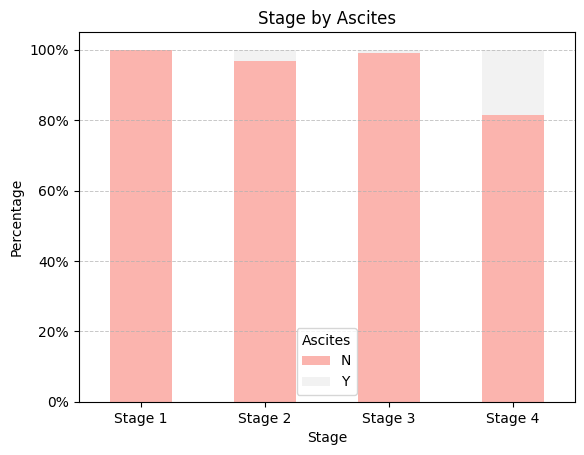

In [30]:
ax= (df.groupby('Stage')['Ascites'].value_counts(normalize=True)
   .unstack('Ascites')
   .plot.bar(stacked=True, colormap='Pastel1')
)

plt.xticks(rotation=0)
plt.title('Stage by Ascites')
plt.xlabel('Stage')
plt.ylabel('Percentage')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

- In stages 1 to 4, the data is dominated by patients who do not have fluid accumulation in the abdominal cavity. However, in stage 4, there are more patients with this fluid accumulation.

#### Stage dan Hepatomegaly

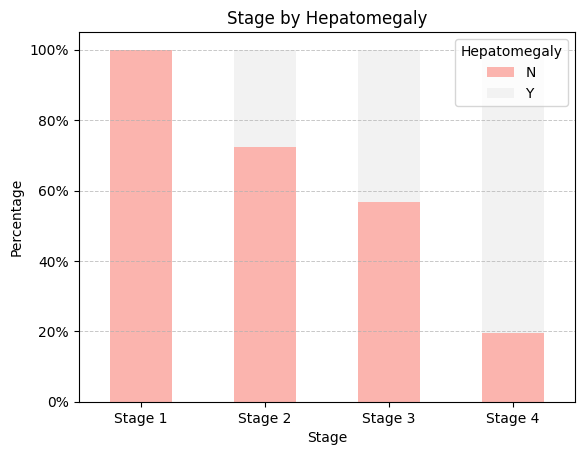

In [31]:
ax= (df.groupby('Stage')['Hepatomegaly'].value_counts(normalize=True)
   .unstack('Hepatomegaly')
   .plot.bar(stacked=True, colormap='Pastel1')
)

plt.xticks(rotation=0)
plt.title('Stage by Hepatomegaly')
plt.xlabel('Stage')
plt.ylabel('Percentage')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

- Liver enlargement occurs in patients in stages 2-4, peaking in stage 4. Meanwhile, no liver enlargement occurs in patients in stage 1.

#### Stage dan Edema

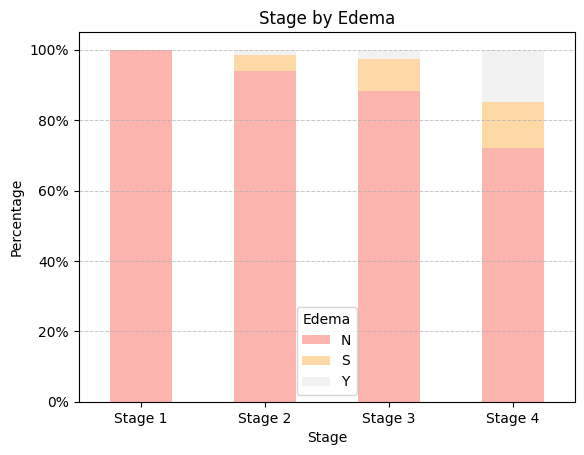

In [32]:
ax= (df.groupby('Stage')['Edema'].value_counts(normalize=True)
   .unstack('Edema')
   .plot.bar(stacked=True, colormap='Pastel1')
)

plt.xticks(rotation=0)
plt.title('Stage by Edema')
plt.xlabel('Stage')
plt.ylabel('Percentage')
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

- In stage 1, all patients do not experience edema/swelling caused by fluid accumulation.
- In stages 2 and 3, the data is dominated by patients who do not experience edema.
- However, in stage 4, the data shows an increase in patients experiencing edema. This is because these patients have fluid accumulation at this stage, as shown in the Ascites column.


#### Stage dan Bilirubin

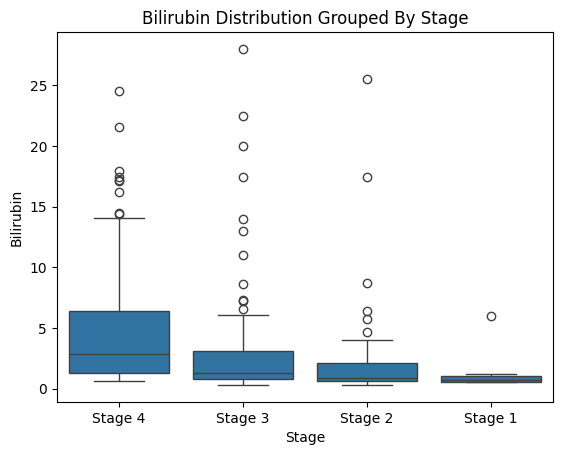

In [33]:
sns.boxplot(data=df, x='Stage', y='Bilirubin')
plt.title('Bilirubin Distribution Grouped By Stage')
plt.show()

- The normal bilirubin level in adults is approximately 0.2 to 1.2 mg/dL. In stage 1, patients still have normal bilirubin levels.
- In stages 2-4, patients exhibit bilirubin variations. Stage 4, with very high and varied bilirubin levels, reflects more severe liver dysfunction caused by Cirrhosis.

#### Stage dan Albumin

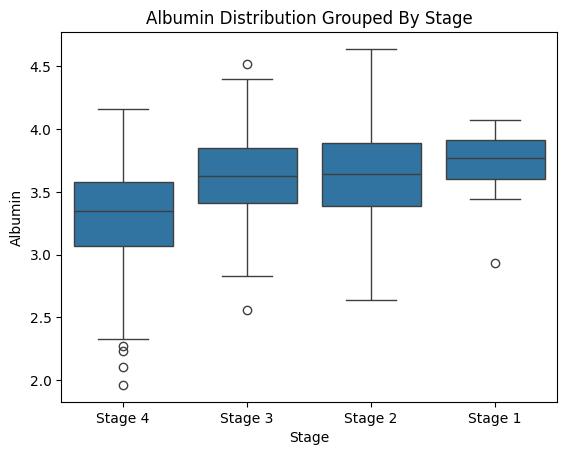

In [34]:
sns.boxplot(data=df, x='Stage', y='Albumin')
plt.title('Albumin Distribution Grouped By Stage')
plt.show()

- Albumin is the main protein in human blood that helps maintain fluid balance inside and outside the blood vessels. Normal albumin levels in blood are 3.5 - 5 g/dL.
- In stage 1, albumin levels are still normal. However, as the stage progresses, patients show varying albumin levels. Stage 4 indicates patients with low albumin levels. This shows that as Cirrhosis worsens, albumin levels in the blood tend to decrease. Low albumin levels reflect impaired liver function because a damaged liver cannot produce sufficient albumin.

#### Stage dan Copper

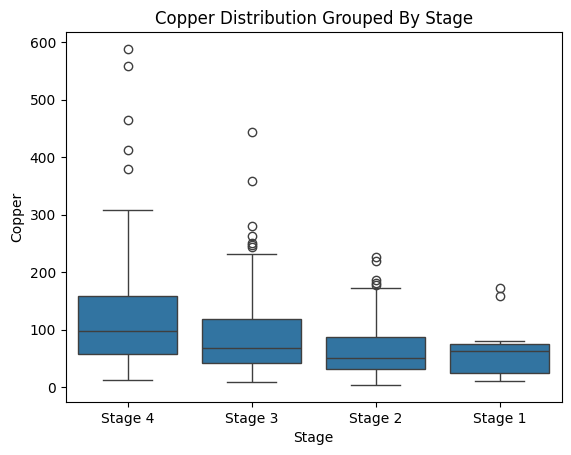

In [35]:
sns.boxplot(data=df, x='Stage', y='Copper')
plt.title('Copper Distribution Grouped By Stage')
plt.show()

- In the early stages (stages 1 and 2), copper excretion might approach normal levels as the liver can still manage most copper metabolism.
- However, in advanced stages (stages 3 and 4), the amount of copper in urine can increase due to liver damage.


#### Stage dan Alkaline Phospatase (U/L)

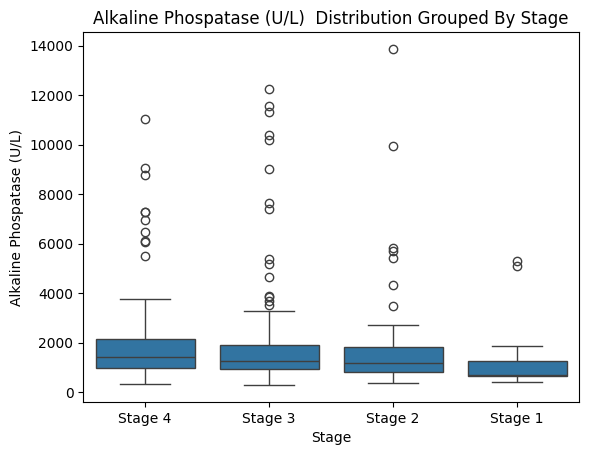

In [36]:
sns.boxplot(data=df, x='Stage', y='Alkaline Phospatase (U/L)')
plt.title('Alkaline Phospatase (U/L)  Distribution Grouped By Stage')
plt.show()

- High ALP levels in the blood may indicate liver disease or specific bone disorders.
- As the stage progresses, ALP levels tend to increase, reflecting the severity of liver damage.
- Outliers in stages 2, 3, and 4 show that some patients have much higher ALP levels, possibly due to severe liver conditions.
- Even though stage 1 shows lower ALP levels, these levels already indicate liver damage.
- Since a fairly significant distribution is still visible in each class, this column still has a correlation with the target column. Therefore, I will not remove this column.

#### Stage dan SGOT

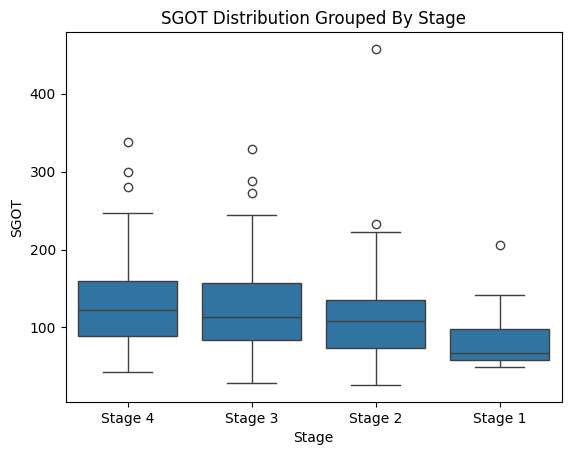

In [37]:
sns.boxplot(data=df, x='Stage', y='SGOT')
plt.title('SGOT Distribution Grouped By Stage')
plt.show()

- In stage 1, SGOT levels are still near normal for most patients, but there are early signs of liver damage in some cases.
- In stages 2 through 4, SGOT increases significantly, with medians far above the normal range, especially in advanced stages (3 and 4). The abundance of outliers in stages 3 and 4 indicates that some patients experience severe liver damage.

#### Stage dan Tryglicerides

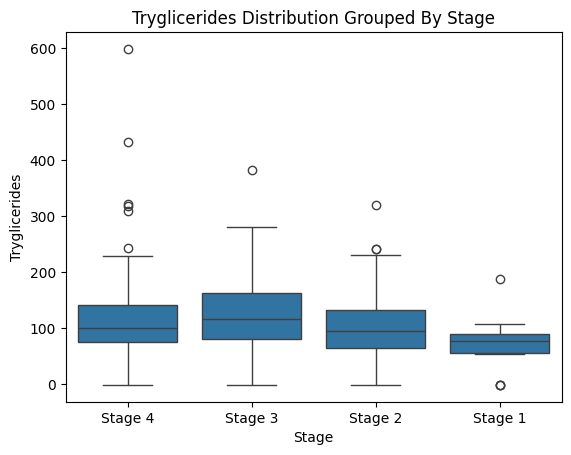

In [38]:
sns.boxplot(data=df, x='Stage', y='Tryglicerides')
plt.title('Tryglicerides Distribution Grouped By Stage')
plt.show()

- Normal triglyceride levels are less than 150 mg/dL.
- In stage 1, patients are still within the normal range, although some exceed it.
- In stages 2-4, patients exhibit triglyceride levels that exceed the normal range. In stage 4, many patients show very high levels, indicating severe liver damage.
- Since a fairly significant distribution is still visible in each class, this column still has a correlation with the target column. Therefore, I will not remove this column.

#### Stage dan Platelets

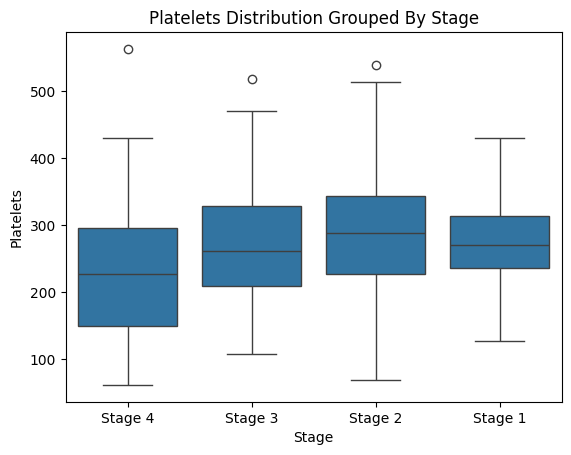

In [39]:
sns.boxplot(data=df, x='Stage', y='Platelets')
plt.title('Platelets Distribution Grouped By Stage')
plt.show()

- Normal platelet levels in an individual are 150 to 450 mL/1000.
- In stage 1, all patients are still within the normal range.
- However, as the stage progresses, platelet variations exceed the normal range.
- Stages 2 and 4 have patients with very low and high platelet levels, far from the normal range. This indicates severe liver damage.

#### Stage dan Prothrombin

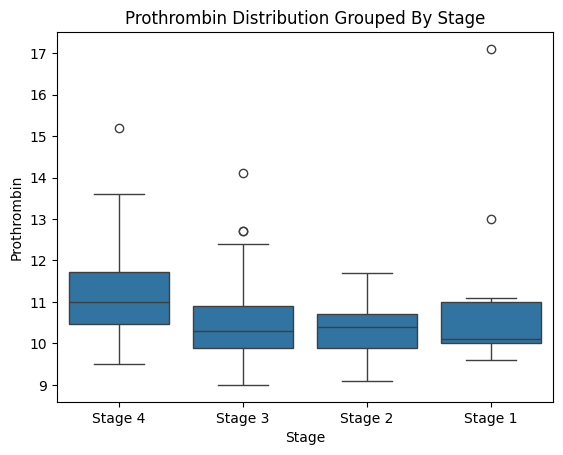

In [40]:
sns.boxplot(data=df, x='Stage', y='Prothrombin')
plt.title('Prothrombin Distribution Grouped By Stage')
plt.show()

- This column measures how quickly blood can clot as a way for the body to stop bleeding. Normal prothrombin time (PT) for individuals not taking blood thinners is 11 to 13.5 seconds.
- All stages are still within the normal range, but some patients show times beyond normal limits.
- As the stage progresses, the range of variation in time needed increases, possibly due to worsening liver damage.

#### Stage dan Age

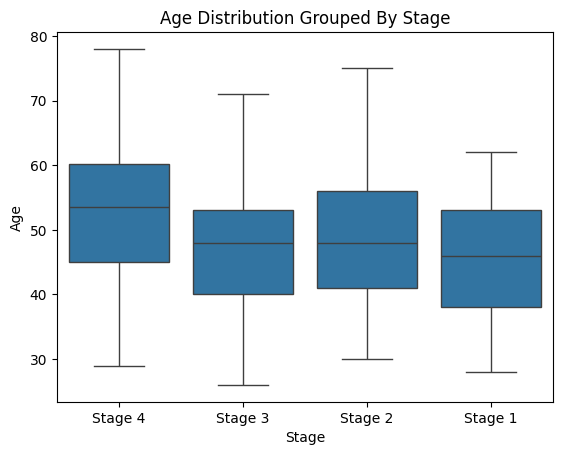

In [41]:
sns.boxplot(data=df, x='Stage', y='Age')
plt.title('Age Distribution Grouped By Stage')
plt.show()

- In each stage, the ages of patients vary widely. However, in stage 4, the age range is very broad, with some patients nearing 80 years old. The median age in stage 4 is higher, indicating that patients at this stage tend to be older.
- In stage 1, the median age is lower compared to other stages, indicating that patients at the early stages tend to be younger.

### Summary EDA

**Numerical Columns:**
- Alkaline Phosphatase (U/L), Copper, SGOT, Triglycerides, and Platelets exhibit wide variations.
- None of the numerical columns are normally distributed, requiring the use of a Robust Scaler for scaling.

**Categorical Columns:**
- There are inconsistent writing anomalies in the Drug and Stage columns.
- The Drug and Hepatomegaly columns exhibit nearly balanced distributions.
- The Gender, Ascites, Edema, and Stage columns exhibit uneven distributions, indicating variations and relationships with other columns.
- Since the Stage column is the target prediction, data sampling techniques are required to balance class distribution for each category. This ensures the model can learn optimally and produce accurate predictions for all classes. An alternative approach could involve using class weights in the Random Forest model and sample weights in the XGBoost model.

**Correlation Analysis:**
- When conducting a correlation analysis using a heatmap, Hepatomegaly, Ascites, Edema, Bilirubin, Copper, and Prothrombin exhibit high correlations with the target. However, some columns show very weak correlations.
- After analyzing each column's distribution against the target column, all columns were found to have significant relationships with the target column. Therefore, no columns will be removed.
- Additionally, Random Forest and XGBoost models can capture non-linear relationships even when there is low correlation between features and the target.
- During the analysis of distributions, some columns were found to be interrelated. For example, the Edema and Ascites columns, where fluid accumulation (Ascites) leads to swelling caused by the same fluid buildup (Edema). This is further supported by a correlation test result of 0.6.

## Feature Engineering

### Encoding


The models to be used are Random Forest and XGBoost, each employing different algorithms.

Random Forest uses a decision-tree-based algorithm that is unaffected by value scaling. Using Label Encoding, the model can still optimally split data without issues. However, in the XGBoost model, Label Encoding can cause the model to misinterpret categorical values as having an order. Therefore, I will use Label Encoding for multi-class columns that do not require value ordering.


**Drug, Gender, Ascites, and Hepatomegaly**
- Since these columns have only two unique values, I will apply binary encoding:
- Drug: D-penicillamine (0) and Placebo (1)
- Gender: F (0) and M (1)
- Ascites: N (0) and Y (1)
- Hepatomegaly: N (0) and Y (1)

**Edema**

- Since this column has three unique values and I do not want any value ordering, I will use one-hot encoding.

**Stage**

- Although this column is multi-class, it represents the severity of the disease. Therefore, it requires value ordering. As such, I will use Label Encoding for this column.

#### Binary Encoding

In [42]:
df['Drug']= df['Drug'].replace({'Placebo': 1, 'D-penicillamine': 0})
df['Gender']= df['Gender'].replace({'M': 1, 'F': 0})
df['Ascites']= df['Ascites'].replace({'Y': 1, 'N': 0})
df['Hepatomegaly']= df['Hepatomegaly'].replace({'Y': 1, 'N': 0})



The changes made:
- Drug: D-penicillamine (0) and Placebo (1)
- Gender: F (0) and M (1)
- Ascites: N (0) and Y (1)
- Hepatomegaly: N (0) and Y (1)

#### One Hot Encoder

In [43]:
encoder= OneHotEncoder(sparse_output=False, drop=None)

encoded_edema= encoder.fit_transform(df[['Edema']])

encoded_columns= pd.DataFrame(
    encoded_edema,
    columns=[f"Edema_{category}" for category in encoder.categories_[0]],
    index=df.index
)
df= pd.concat([df, encoded_columns.astype('int')], axis=1)
df= df.drop(columns=['Edema'])

#### Label Encoder

In [44]:
label_encoder= LabelEncoder()

df['Stage_encoded']= label_encoder.fit_transform(df['Stage'])

stage_mapping= dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Perubahan Nilai:")
for key, value in stage_mapping.items():
    print(f"{key} -> {value}")

df= df.drop(columns=['Stage'])

Perubahan Nilai:
Stage 1 -> 0
Stage 2 -> 1
Stage 3 -> 2
Stage 4 -> 3


The changes made:
- Stage 1 becomes 0
- Stage 2 becomes 1
- Stage 3 becomes 2
- Stage 4 becomes 3

### Re-check the Data

In [45]:
df.head()

,Drug,Gender,Ascites,Hepatomegaly,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Age,Edema_N,Edema_S,Edema_Y,Stage_encoded
0,0,0,1,1,14.5,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,58,0,0,1,3
1,0,0,0,1,1.1,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,56,1,0,0,2
2,0,1,0,0,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,70,0,1,0,3
3,0,0,0,1,1.8,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,54,0,1,0,3
4,1,0,0,1,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,38,1,0,0,2


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306 entries, 0 to 311
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Drug                       306 non-null    int64  
 1   Gender                     306 non-null    int64  
 2   Ascites                    306 non-null    int64  
 3   Hepatomegaly               306 non-null    int64  
 4   Bilirubin                  306 non-null    float64
 5   Albumin                    306 non-null    float64
 6   Copper                     306 non-null    float64
 7   Alkaline Phospatase (U/L)  306 non-null    float64
 8   SGOT                       306 non-null    float64
 9   Tryglicerides              306 non-null    float64
 10  Platelets                  306 non-null    float64
 11  Prothrombin                306 non-null    float64
 12  Age                        306 non-null    int64  
 13  Edema_N                    306 non-null    int32  
 14 

- The data structure now conforms to the label encoding naming convention.
- All data is now in numeric format, making it ready for modeling.

## Splitting Data

In [47]:
x= df[df.columns.drop(['Stage_encoded'])]
y= df['Stage_encoded']

x_train, x_test, y_train, y_test= train_test_split(x,y, test_size=0.2,random_state=123)
print(x_train.shape,x_test.shape)

(244, 16) (62, 16)


In [48]:
print("Distribusi kelas sebelum oversampling:")
print(pd.Series(y_train).value_counts())

Distribusi kelas sebelum oversampling:
Stage_encoded
2    101
3     81
1     50
0     12
Name: count, dtype: int64


- Due to the unbalanced distribution in each class, I will apply oversampling.

## Oversampling

In [49]:
smote= SMOTE(random_state= 44)
x_train_resampled, y_train_resampled= smote.fit_resample(x_train, y_train)

print("Setelah oversampling:", x_train_resampled.shape, y_train_resampled.shape)

Setelah oversampling: (404, 16) (404,)


In [50]:
print("Distribusi kelas setelah oversampling:")
print(pd.Series(y_train_resampled).value_counts())

Distribusi kelas setelah oversampling:
Stage_encoded
1    101
3    101
2    101
0    101
Name: count, dtype: int64




- As mentioned in the EDA, oversampling is my first approach to enable the model to better predict minority classes.
- After oversampling, all classes are now evenly distributed.

## Scaling

In [51]:
robust= RobustScaler()

x_train_resampled= robust.fit_transform(x_train_resampled)
x_test= robust.transform(x_test)

- Robust Scaler is used since the data is not normally distributed, as confirmed by the Shapiro test conducted during the EDA.

## Train Model

### Random Forest

In [219]:
class_weights= compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train
)
class_weight_dict= {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 5.083333333333333, 1: 1.22, 2: 0.6039603960396039, 3: 0.7530864197530864}

- I applied the class-weight approach to allow the model to focus more on predictions in minority classes.
- In the `class_weight_dict`, class 0 has a much higher weight than other classes. This weight will help the model predict class 0 more effectively.

In [53]:
rf= RandomForestClassifier(random_state=42, class_weight=class_weight_dict, criterion= 'gini',max_depth= 4, n_estimators=100)
rf.fit(x_train_resampled, y_train_resampled)
y_pred= rf.predict(x_test)

#### Evaluation

              precision    recall  f1-score   support

           0       0.17      0.67      0.27         3
           1       0.29      0.27      0.28        15
           2       0.50      0.06      0.11        17
           3       0.68      0.85      0.75        27

    accuracy                           0.48        62
   macro avg       0.41      0.46      0.35        62
weighted avg       0.51      0.48      0.44        62



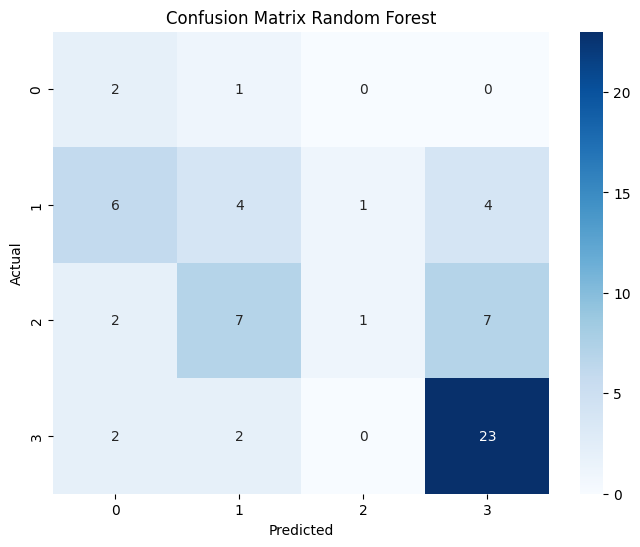

In [54]:
print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test, y_pred)
labels= np.unique(y)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Random Forest")
plt.show()

- Evaluation for each class on the Classification Report:

    - 0:
        - Precision: 0.17, which means 17% of predictions made by the model as class 0 are correct.
        - Recall: 0.67, which means 67% of actual class 0 data is correctly identified by the model.
        - F1-Score: 0.27, indicating poor performance.

    - 1:
        - Precision: 0.29, which means 29% of predictions as class 1 are correct.
        - Recall: 0.27, which means 27% of actual class 1 data is correctly identified by the model.
        - F1-Score: 0.28, indicating poor performance.

    - 2:
        - Precision: 0.50, which means 50% of predictions as class 2 are correct.
        - Recall: 0.06, showing that only 6% of class 2 data is correctly identified by the model.
        - F1-Score: 0.11, indicating very poor performance.

    - 3:
        - Precision: 0.68, which means 68% of predictions as class 3 are correct.
        - Recall: 0.85, showing that 85% of class 3 data is correctly identified by the model.
        - F1-Score: 0.75, indicating good performance.

Macro avg recall of 0.46 and macro avg f1-score of 0.35 show that the model has poor performance overall without being overly influenced by class sizes.

- Evaluation for each class on the Confusion Matrix:

    - Class 0:
        - TP: 2 data points are correctly predicted as class 0.
        - FP: 2 + 6 + 2 = 10 data points are incorrectly predicted as class 0.
        - FN: 1 + 0 + 0 = 1 data point is incorrectly predicted as another class.
        - TN: (4+1+4) + (7+1+7) + (2+0+23) = 49 data points are correctly predicted as other classes.

    - Class 1:
        - TP: 4 data points are correctly predicted as class 1.
        - FP: 1 + 7 + 2 = 10 data points are incorrectly predicted as class 1.
        - FN: 6 + 1 + 4 = 11 data points are incorrectly predicted as other classes.
        - TN: (2+0+0) + (2+1+7) + (2+0+23) = 57 data points are correctly predicted as other classes.

    - Class 2:
        - TP: 1 data point is correctly predicted as class 2.
        - FP: 0 + 1 + 0 = 1 data point is incorrectly predicted as class 2.
        - FN: 2 + 7 + 7 = 16 data points are incorrectly predicted as other classes.
        - TN: (2+1+0) + (6+4+4) + (2+2+23) = 63 data points are correctly predicted as other classes.

    - Class 3:
        - TP: 23 data points are correctly predicted as class 3.
        - FP: 0 + 4 + 7 = 11 data points are incorrectly predicted as class 3.
        - FN: 2 + 2 + 0 = 4 data points are incorrectly predicted as other classes.
        - TN: (2+1+0) + (6+4+1) + (2+7+1) = 48 data points are correctly predicted as other classes.


Summary Analysis:
  - Based on the results, the model performs variably across classes, with class 3 showing the best performance, while other classes show very low performance. This highlights the imbalance in the model's ability to handle different classes. Therefore, further model optimization is required.


#### Fine Tuning Random Forest

In [55]:
param_grid= {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf= RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

In [56]:
grid_search= GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='f1_macro',
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(x_train_resampled, y_train_resampled)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 200}


In [57]:
best_rf = grid_search.best_estimator_
best_rf

RandomForestClassifier(class_weight={0: 5.083333333333333, 1: 1.22,
                                     2: 0.6039603960396039,
                                     3: 0.7530864197530864},
                       criterion='entropy', max_depth=6, n_estimators=200,
                       random_state=42)

In [58]:
y_pred = best_rf.predict(x_test)

#### Re-Evaluate Model After Tuning

Classification Report after Tuning:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40         3
           1       0.50      0.40      0.44        15
           2       0.38      0.29      0.33        17
           3       0.73      0.81      0.77        27

    accuracy                           0.56        62
   macro avg       0.48      0.54      0.49        62
weighted avg       0.56      0.56      0.55        62



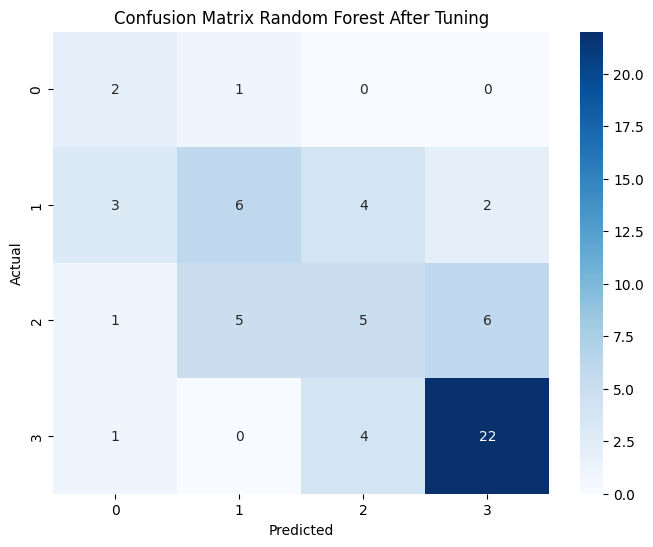

In [59]:
print("Classification Report after Tuning:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Random Forest After Tuning")
plt.show()

  - Evaluation for each class on the Classification Report:

      - Class 0:
          - Precision: 0.29, which means 29% of predictions made by the model as class 0 are correct.
          - Recall: 0.67, which means 67% of actual class 0 data is correctly identified by the model.
          - F1-Score: 0.40, indicating significantly improved performance.

      - Class 1:
         - Precision: 0.50, which means 50% of predictions as class 1 are correct.
          - Recall: 0.40, which means 40% of actual class 1 data is correctly identified by the model.
          - F1-Score: 0.44, indicating improved performance.

      - Class 2:
          - Precision: 0.38, which means 38% of predictions as class 2 are correct.
          - Recall: 0.29, showing that 29% of class 2 data is correctly identified by the model.
          - F1-Score: 0.33, indicating better performance.

      - Class 3:
          - Precision: 0.73, which means 73% of predictions as class 3 are correct.
          - Recall: 0.81, showing that 81% of class 3 data is correctly identified by the model.
          - F1-Score: 0.77, indicating significantly improved performance.

      - Macro avg recall: 0.54 and Macro avg F1-score: 0.49 indicate overall better performance across all classes.

- Evaluation for each class on the Confusion Matrix:

    - Class 0:
        - TP: 2 data points are correctly predicted as class 0.
        - FP: 3 + 1 + 1 = 5 data points are incorrectly predicted as class 0.
        - FN: 1 + 0 + 0 = 1 data point is incorrectly predicted as another class.
        - TN: (6+4+2) + (5+5+6) + (0+4+22) = 54 data points are correctly predicted as other classes.

    - Class 1:
        - TP: 6 data points are correctly predicted as class 1.
        - FP: 1 + 5 + 0 = 6 data points are incorrectly predicted as class 1.
        - FN: 3 + 4 + 2 = 9 data points are incorrectly predicted as other classes.
        - TN: (2+0+0) + (1+5+6) + (1+4+22) = 41 data points are correctly predicted as other classes.

    - Class 2:
        - TP: 5 data points are correctly predicted as class 2.
        - FP: 0 + 4 + 4 = 8 data points are incorrectly predicted as class 2.
        - FN: 1 + 5 + 6 = 12 data points are incorrectly predicted as other classes.
        - TN: (2+1+0) + (3+6+2) + (1+0+22) = 37 data points are correctly predicted as other classes.

    - Class 3:
        - TP: 22 data points are correctly predicted as class 3.
        - FP: 0 + 2 + 6 = 8 data points are incorrectly predicted as class 3.
        - FN: 1 + 0 + 4 = 5 data points are incorrectly predicted as other classes.
        - TN: (2+1+0) + (3+6+4) + (1+5+5) = 27 data points are correctly predicted as other classes.


- Analysis:
    - After fine-tuning, all classes experienced an increase in F1-score, indicating that the model's performance in predicting each class has significantly improved. Although precision for class 2 decreased, recall for class 2 improved, suggesting that the model is better at detecting class 2.
    - The model is now better at detecting minority classes, particularly class 0 and 1.
    - The increase in True Positive values confirms that the model is now better at predicting each class accurately.
    - Overall, the increased macro average F1-score demonstrates that the model's overall performance has improved.
    - However, the model still tends to predict class 3 more accurately due to the initial imbalance in data distribution.

### XGBoost 

In [237]:
class_weights= compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_resampled),
    y=y_train
)
class_weight_dict= {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

sample_weight = np.array([class_weight_dict[label] for label in y_train_resampled])

xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    min_child_weight=50,
    max_depth=8
)
xgb_model.fit(x_train_resampled, y_train_resampled, sample_weight= sample_weight)

y_pred = xgb_model.predict(x_test)

- The use of `sample_weight` was applied to XGBoost to improve its ability to predict minority classes. This `sample_weight` was created based on the `class_weight` used in Random Forest.

#### Evaluation

              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.21      0.20      0.21        15
           2       0.22      0.12      0.15        17
           3       0.67      0.59      0.63        27

    accuracy                           0.37        62
   macro avg       0.31      0.39      0.30        62
weighted avg       0.41      0.37      0.38        62



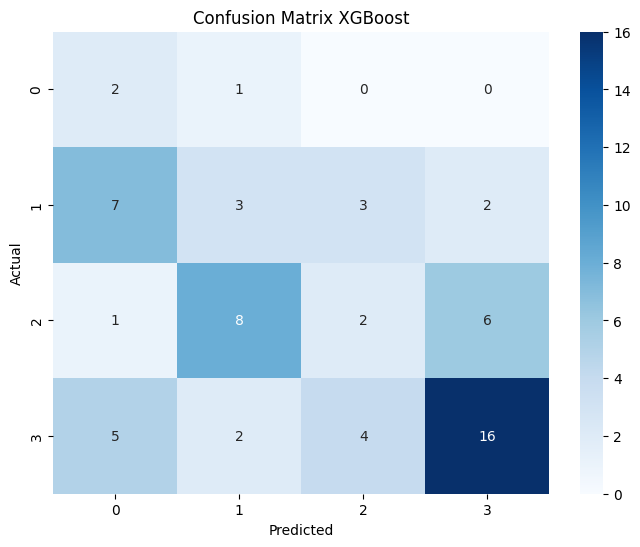

In [239]:
print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test, y_pred)
labels= np.unique(y)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix XGBoost")
plt.show()

- Evaluation for each class on the Classification Report:

    - Class 0:
        - Precision: 0.13, meaning 13% of predictions as class 0 are correct.
        - Recall: 0.67, meaning 67% of actual class 0 data is correctly identified by the model.
        - F1-Score: 0.22, indicating poor performance.

    - Class 1:
        - Precision: 0.21, meaning 21% of predictions as class 1 are correct.
        - Recall: 0.20, meaning 20% of actual class 1 data is correctly identified by the model.
        - F1-Score: 0.21, indicating poor performance.

    - Class 2:
        - Precision: 0.22, meaning 22% of predictions as class 2 are correct.
        - Recall: 0.12, meaning 12% of actual class 2 data is correctly identified by the model.
        - F1-Score: 0.15, indicating very poor performance.

    - Class 3:
        - Precision: 0.67, meaning 67% of predictions as class 3 are correct.
        - Recall: 0.59, meaning 59% of actual class 3 data is correctly identified by the model.
        - F1-Score: 0.63, indicating moderate performance.

    - Macro avg recall: 0.39 and Macro avg F1-score: 0.30 indicate that the model's overall performance is poor.


  - Evaluation for each class on the Confusion Matrix:

    - Class 0:
        - TP: 2 data points are correctly predicted as class 0.
        - FP: 7 + 1 + 5 = 13 data points are incorrectly predicted as class 0.
        - FN: 1 + 0 + 0 = 1 data point is incorrectly predicted as another class.
        - TN: (3+3+2) + (8+2+6) + (2+14+16) = 56 data points are correctly predicted as other classes.

    - Class 1:
        - TP: 3 data points are correctly predicted as class 1.
        - FP: 1 + 8 + 2 = 11 data points are incorrectly predicted as class 1.
        - FN: 7 + 3 + 2 = 12 data points are incorrectly predicted as other classes.
        - TN: (2+0+0) + (1+2+6) + (5+4+16) = 36 data points are correctly predicted as other classes.

    - Class 2:
        - TP: 2 data points are correctly predicted as class 2.
        - FP: 0 + 2 + 4 = 6 data points are incorrectly predicted as class 2.
        - FN: 1 + 8 + 6 = 15 data points are incorrectly predicted as other classes.
        - TN: (2+1+0) + (7+3+2) + (5+2+16) = 38 data points are correctly predicted as other classes.

    - Class 3:
        - TP: 16 data points are correctly predicted as class 3.
        - FP: 0 + 2 + 6 = 8 data points are incorrectly predicted as class 3.
        - FN: 5 + 2 + 4 = 11 data points are incorrectly predicted as other classes.
        - TN: (2+1+0) + (7+3+3) + (1+8+2) = 27 data points are correctly predicted as other classes.


- Summary Analysis:
    - Based on the results, class 3 shows the best performance, while the other classes perform very poorly, reflecting the model's imbalance in handling different classes. Therefore, further optimization of the model is required. Compared to the Random Forest model, XGBoost demonstrates much lower performance in both the classification report and the confusion matrix.


#### Fine Tuning XGBoost

In [324]:
param_grid= {
    'n_estimators': [150, 160, 165],
    'max_depth': [8, 9, 10],
    'min_child_weight': [50, 57, 60],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb_model = XGBClassifier(random_state=42)

In [325]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',         
    cv=5,
    verbose=2,
    n_jobs=-1                  
)
grid_search.fit(x_train_resampled, y_train_resampled, sample_weight=sample_weight)

print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 50, 'n_estimators': 165}


In [326]:
best_xg= grid_search.best_estimator_
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=165, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [327]:
y_pred = best_xg.predict(x_test)

#### Re-Evaluate Model After Tuning

Classification Report after Tuning:
              precision    recall  f1-score   support

           0       0.13      0.67      0.22         3
           1       0.25      0.27      0.26        15
           2       0.30      0.18      0.22        17
           3       0.67      0.52      0.58        27

    accuracy                           0.37        62
   macro avg       0.34      0.41      0.32        62
weighted avg       0.44      0.37      0.39        62



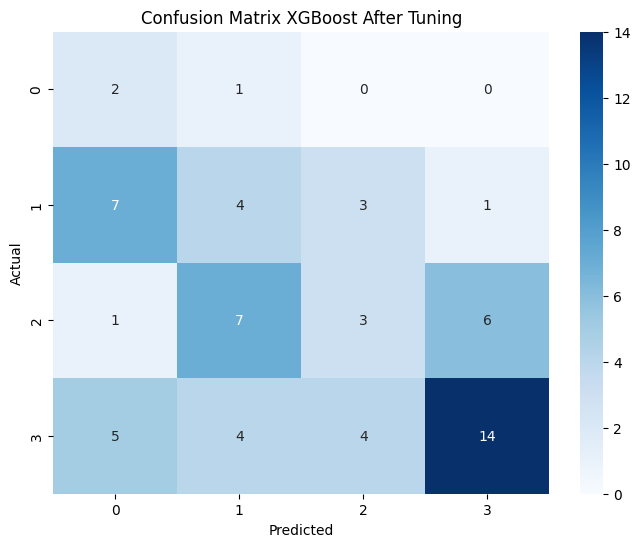

In [328]:
print("Classification Report after Tuning:")
print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test, y_pred)
labels= np.unique(y)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix XGBoost After Tuning")
plt.show()


- Evaluation for each class on the Classification Report:

    - Class 0:
        - Precision: 0.13, meaning 13% of predictions as class 0 are correct.
        - Recall: 0.67, meaning 67% of actual class 0 data is correctly identified by the model.
        - F1-Score: 0.22, indicating the same performance as before tuning.

    - Class 1:
        - Precision: 0.25, meaning 25% of predictions as class 1 are correct.
        - Recall: 0.27, meaning 27% of actual class 1 data is correctly identified by the model.
        - F1-Score: 0.26, showing slightly better performance.

    - Class 2:
        - Precision: 0.30, meaning 30% of predictions as class 2 are correct.
        - Recall: 0.18, meaning 18% of actual class 2 data is correctly identified by the model.
        - F1-Score: 0.22, showing slightly better performance.

    - Class 3:
        - Precision: 0.67, meaning 67% of predictions as class 3 are correct.
        - Recall: 0.52, meaning 52% of actual class 3 data is correctly identified by the model.
        - F1-Score: 0.58, showing slightly worse performance.

    - Macro avg recall: 0.41 and Macro avg F1-score: 0.32 indicate slightly better overall performance.


- Evaluation for each class on the Confusion Matrix:

    - Class 0:
        - TP: 2 data points are correctly predicted as class 0.
        - FP: 7 + 1 + 5 = 13 data points are incorrectly predicted as class 0.
        - FN: 1 + 0 + 0 = 1 data point is incorrectly predicted as another class.
        - TN: (4+3+1) + (7+3+6) + (4+4+14) = 46 data points are correctly predicted as other classes.

    - Class 1:
        - TP: 4 data points are correctly predicted as class 1.
        - FP: 1 + 7 + 4 = 12 data points are incorrectly predicted as class 1.
        - FN: 7 + 3 + 1 = 11 data points are incorrectly predicted as another class.
        - TN: (2+0+0) + (1+3+6) + (5+4+14) = 35 data points are correctly predicted as other classes.

    - Class 2:
        - TP: 3 data points are correctly predicted as class 2.
        - FP: 0 + 3 + 4 = 7 data points are incorrectly predicted as class 2.
        - FN: 1 + 7 + 6 = 14 data points are incorrectly predicted as another class.
        - TN: (2+1+0) + (7+4+1) + (5+4+14) = 38 data points are correctly predicted as other classes.

    - Class 3:
        - TP: 14 data points are correctly predicted as class 3.
        - FP: 0 + 1 + 6 = 7 data points are incorrectly predicted as class 3.
        - FN: 5 + 4 + 4 = 13 data points are incorrectly predicted as another class.
        - TN: (2+1+0) + (7+4+3) + (1+7+3) = 28 data points are correctly predicted as other classes.


- Analysis:
    - After fine-tuning, F1-scores for classes 0, 1, and 2 have improved, indicating that the model's ability to predict these classes correctly has improved.
    - However, the model performed worse for class 3, as indicated by a decline in recall and True Positive values.
    - Despite this, the model is better at detecting minority classes, such as class 0 and 1. This is supported by an increase in True Positive values for these classes.
    - Overall, the increase in macro average F1-score indicates that the model's overall performance has improved.
    - However, the model still tends to predict class 3 more accurately due to the initial imbalance in data distribution.


### Conclusion to Decide Best Model

- After comparing both models post-tuning, it is concluded that the Random Forest model is significantly better than XGBoost. This is evidenced by all metrics (precision, recall, accuracy, F1-score, True Positive, and Macro average) being higher for the Random Forest model.

- As an initial comparison, Random Forest achieved an accuracy of 0.56, while XGBoost only achieved 0.37. This significant difference already shows that Random Forest predicts much better. However, accuracy alone is not sufficient to determine the better model. Therefore, deeper analysis of True Positive, F1-score, macro values, precision, and recall is needed.

- Random Forest correctly identifies 2, 6, 5, and 22 data points for classes 0, 1, 2, and 3, respectively. In comparison, XGBoost only correctly identifies 2, 4, 3, and 14 data points for the same classes. For classes 0, 1, and 2, Random Forest has F1-scores above 0.33, whereas XGBoost does not exceed 0.26. Even for the majority class (class 3), XGBoost only achieves an F1-score of 0.58, while Random Forest achieves 0.77. This significant difference highlights that Random Forest is a much better model.

- Overall, Random Forest achieves a higher macro average F1-score of 0.49, compared to XGBoost at 0.32. This proves that Random Forest can better predict (precision) and detect (recall) each class, especially for highly imbalanced data.

- This evidence leads to the decision that Random Forest is the best model.

## Feature Importances on the Best Model

                      Feature  Importance
7   Alkaline Phospatase (U/L)    0.152846
3                Hepatomegaly    0.132719
8                        SGOT    0.110098
4                   Bilirubin    0.105827
9               Tryglicerides    0.085454
11                Prothrombin    0.083032
5                     Albumin    0.076962
6                      Copper    0.068062
12                        Age    0.067914
10                  Platelets    0.057025
0                        Drug    0.035253
13                    Edema_N    0.019109
1                      Gender    0.002173
2                     Ascites    0.001692
14                    Edema_S    0.001319
15                    Edema_Y    0.000514


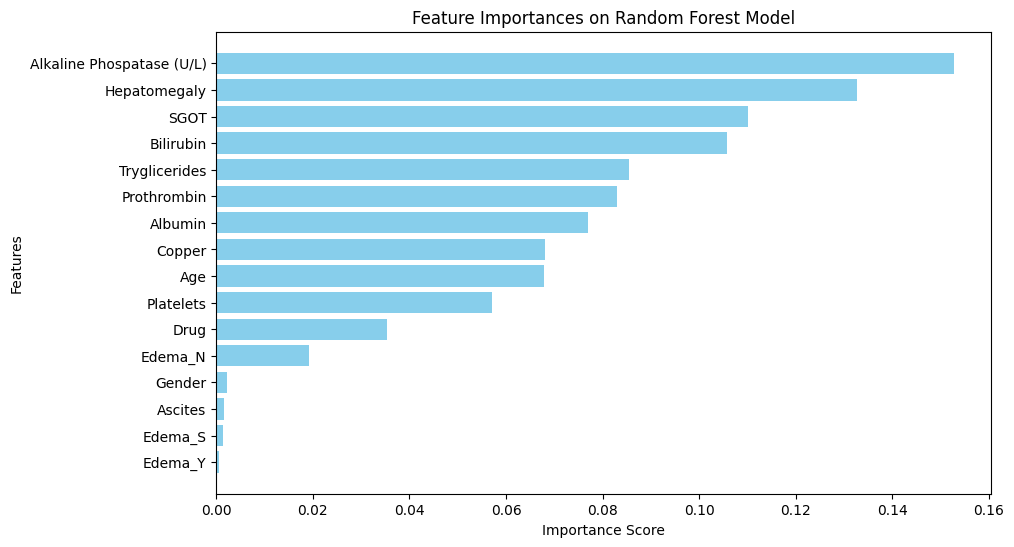

In [333]:
feature_importances= best_rf.feature_importances_

feature_names= x.columns

importance_df= pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

importance_df= importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title('Feature Importances on Random Forest Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

- Based on the results, Alkaline Phosphatase is the most important feature in the model. High or low levels of alkaline phosphatase are highly relevant in determining the stage of patients with Cirrhosis.

- Additionally, Hepatomegaly (liver enlargement), SGOT, and Bilirubin are also crucial features for determining the stage of the disease. These four features are selected due to their importance scores exceeding 0.1.

- The significance of these values has been proven through the distribution of each feature with the target column, where these features show significant changes at each stage. This allows the model to learn the patterns and characteristics of each stage through these features.